# LSTM with pretrained model

In [1]:
from IPython.display import clear_output

# Guys, put the kaggle.json File in your drive before running this code here.
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [2]:
!kaggle datasets download -d toluwaniaremu/smartcity-cctv-violence-detection-dataset-scvd

100% 959M/960M [00:44<00:00, 26.0MB/s]
100% 960M/960M [00:44<00:00, 22.8MB/s]


In [3]:
! mkdir kaggle_data
! unzip {"smartcity-cctv-violence-detection-dataset-scvd" + ".zip"} -d kaggle_data
clear_output()

In [4]:
!pip install pytorchvideo
clear_output()

In [5]:
!pip install pytorch_lightning
clear_output()


In [6]:
import shutil
import pandas as pd
from glob import glob
from IPython.display import HTML
from base64 import b64encode


import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix

from pytorchvideo.data import make_clip_sampler, labeled_video_dataset

from pytorchvideo.transforms import(
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Permute
)
from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    Resize
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_lightning import  seed_everything , Trainer , LightningDataModule,LightningModule

from pytorch_lightning.callbacks import ModelCheckpoint , LearningRateMonitor
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data.distributed import T_co

import seaborn as sns


%matplotlib inline

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [7]:
ls = !ls {'/content/kaggle_data/SCVD/videos'}
ls

["'Non-Violence Videos'  'violence video cleaned'  'Weapon Violence'"]

In [8]:
CLASSES = ['Non-Violence Videos', 'violence video cleaned', 'Weapon Violence']
CLASSES[0]

'Non-Violence Videos'

In [9]:
from tqdm import tqdm
import os

PROJECT_DIR = '/content/kaggle_data/SCVD'
VideoDataDir = PROJECT_DIR + '/videos'
print('we have \n{} Violence videos \n{} NonViolence videos \n{} Weapon Violence videos'.format(
              len(os.listdir(VideoDataDir + '/violence video cleaned')),
              len(os.listdir(VideoDataDir + '/Non-Violence Videos')),
              len(os.listdir(VideoDataDir + '/Weapon Violence'))))


we have 
112 Violence videos 
246 NonViolence videos 
124 Weapon Violence videos


In [10]:

file_path = '/content/kaggle_data/SCVD/videos/'

Non_Violence = glob(file_path + 'Non-Violence Videos/*') # class 0
Weapon_Violence = glob(file_path + 'Weapon Violence/*') # class 1
Normal_Violence = glob(file_path + 'violence video cleaned/*') # class 2
label=[0]*len(Non_Violence) + [1]*len(Weapon_Violence) + [2]*len(Normal_Violence)
df=pd.DataFrame(zip(Non_Violence + Normal_Violence + Weapon_Violence,label), columns = ['file','label'])

In [11]:
df

,file,label
0,/content/kaggle_data/SCVD/videos/Non-Violence ...,0
1,/content/kaggle_data/SCVD/videos/Non-Violence ...,0
2,/content/kaggle_data/SCVD/videos/Non-Violence ...,0
3,/content/kaggle_data/SCVD/videos/Non-Violence ...,0
4,/content/kaggle_data/SCVD/videos/Non-Violence ...,0
...,...,...
477,/content/kaggle_data/SCVD/videos/Weapon Violen...,2
478,/content/kaggle_data/SCVD/videos/Weapon Violen...,2
479,/content/kaggle_data/SCVD/videos/Weapon Violen...,2
480,/content/kaggle_data/SCVD/videos/Weapon Violen...,2


In [12]:
# 70% - 15% - 15%
train_df, val_df = train_test_split(df, test_size=0.30, shuffle=True, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.50, shuffle=True, stratify=val_df['label'], random_state=42)


# Define the base directory for the train folder

# Base directories for train, validation, and test folders
base_dirs = {
    "train": "/content/dataset/train",
    "validation": "/content/dataset/validation",
    "test": "/content/dataset/test"
}

# Define subfolders based on label names
subfolders = {
    0: "Non-Violence Videos",
    1: "Weapon Violence",
    2: "Violence Video Cleaned"
}

# Function to create directories and move files
def move_files(df, base_dir):
    # Create the base directory and subdirectories if they don't exist
    os.makedirs(base_dir, exist_ok=True)
    for subfolder in subfolders.values():
        os.makedirs(os.path.join(base_dir, subfolder), exist_ok=True)

    # Iterate over the DataFrame and move each file
    for index, row in df.iterrows():
        file_path = row['file']
        label = row['label']
        subfolder_name = subfolders[label]
        destination_folder = os.path.join(base_dir, subfolder_name)

        # Move the file
        shutil.move(file_path, os.path.join(destination_folder, os.path.basename(file_path)))

# Move files for each dataset
for dataset_type, df in zip(["train", "validation", "test"], [train_df, val_df, test_df]):
    move_files(df, base_dirs[dataset_type])

print("Files for train, validation, and test datasets moved successfully.")


Files for train, validation, and test datasets moved successfully.


In [13]:
video_transforms = Compose([
    ApplyTransformToKey(key= 'video', # we will have so many keys to apply the transforms to, we are interested in video key only.
    transform = Compose([
     UniformTemporalSubsample(20), # number of frames per a sec
     Lambda(lambda x: x / 255),
     Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
     RandomShortSideScale(min_size=400, max_size=720), # max height I found was 720
     CenterCropVideo(224),
     RandomHorizontalFlip(p = 0.5),
     RandomVerticalFlip(p=0.5)
    ]),
  ),
])

In [14]:
train_dataset_labeled = labeled_video_dataset(
    "/content/dataset/train/",
    clip_sampler=make_clip_sampler('random', 2),
    transform=video_transforms,
    decode_audio=False
)

validation_dataset_labeled = labeled_video_dataset(
    "/content/dataset/validation/",
    clip_sampler=make_clip_sampler('random', 2),
    transform=video_transforms,
    decode_audio=False
)
test_dataset_labeled = labeled_video_dataset(
    "/content/dataset/test/",
    clip_sampler=make_clip_sampler('random', 2),
    transform=video_transforms,
    decode_audio=False
)


In [15]:
torch.cuda.empty_cache()
train_loader = DataLoader(train_dataset_labeled, batch_size=8, pin_memory = True, num_workers = 8)
valid_loader = DataLoader(validation_dataset_labeled, batch_size=8, pin_memory = True, num_workers = 8)
test_laoder  = DataLoader(test_dataset_labeled, batch_size=8, pin_memory = True, num_workers = 8)


# Building the model

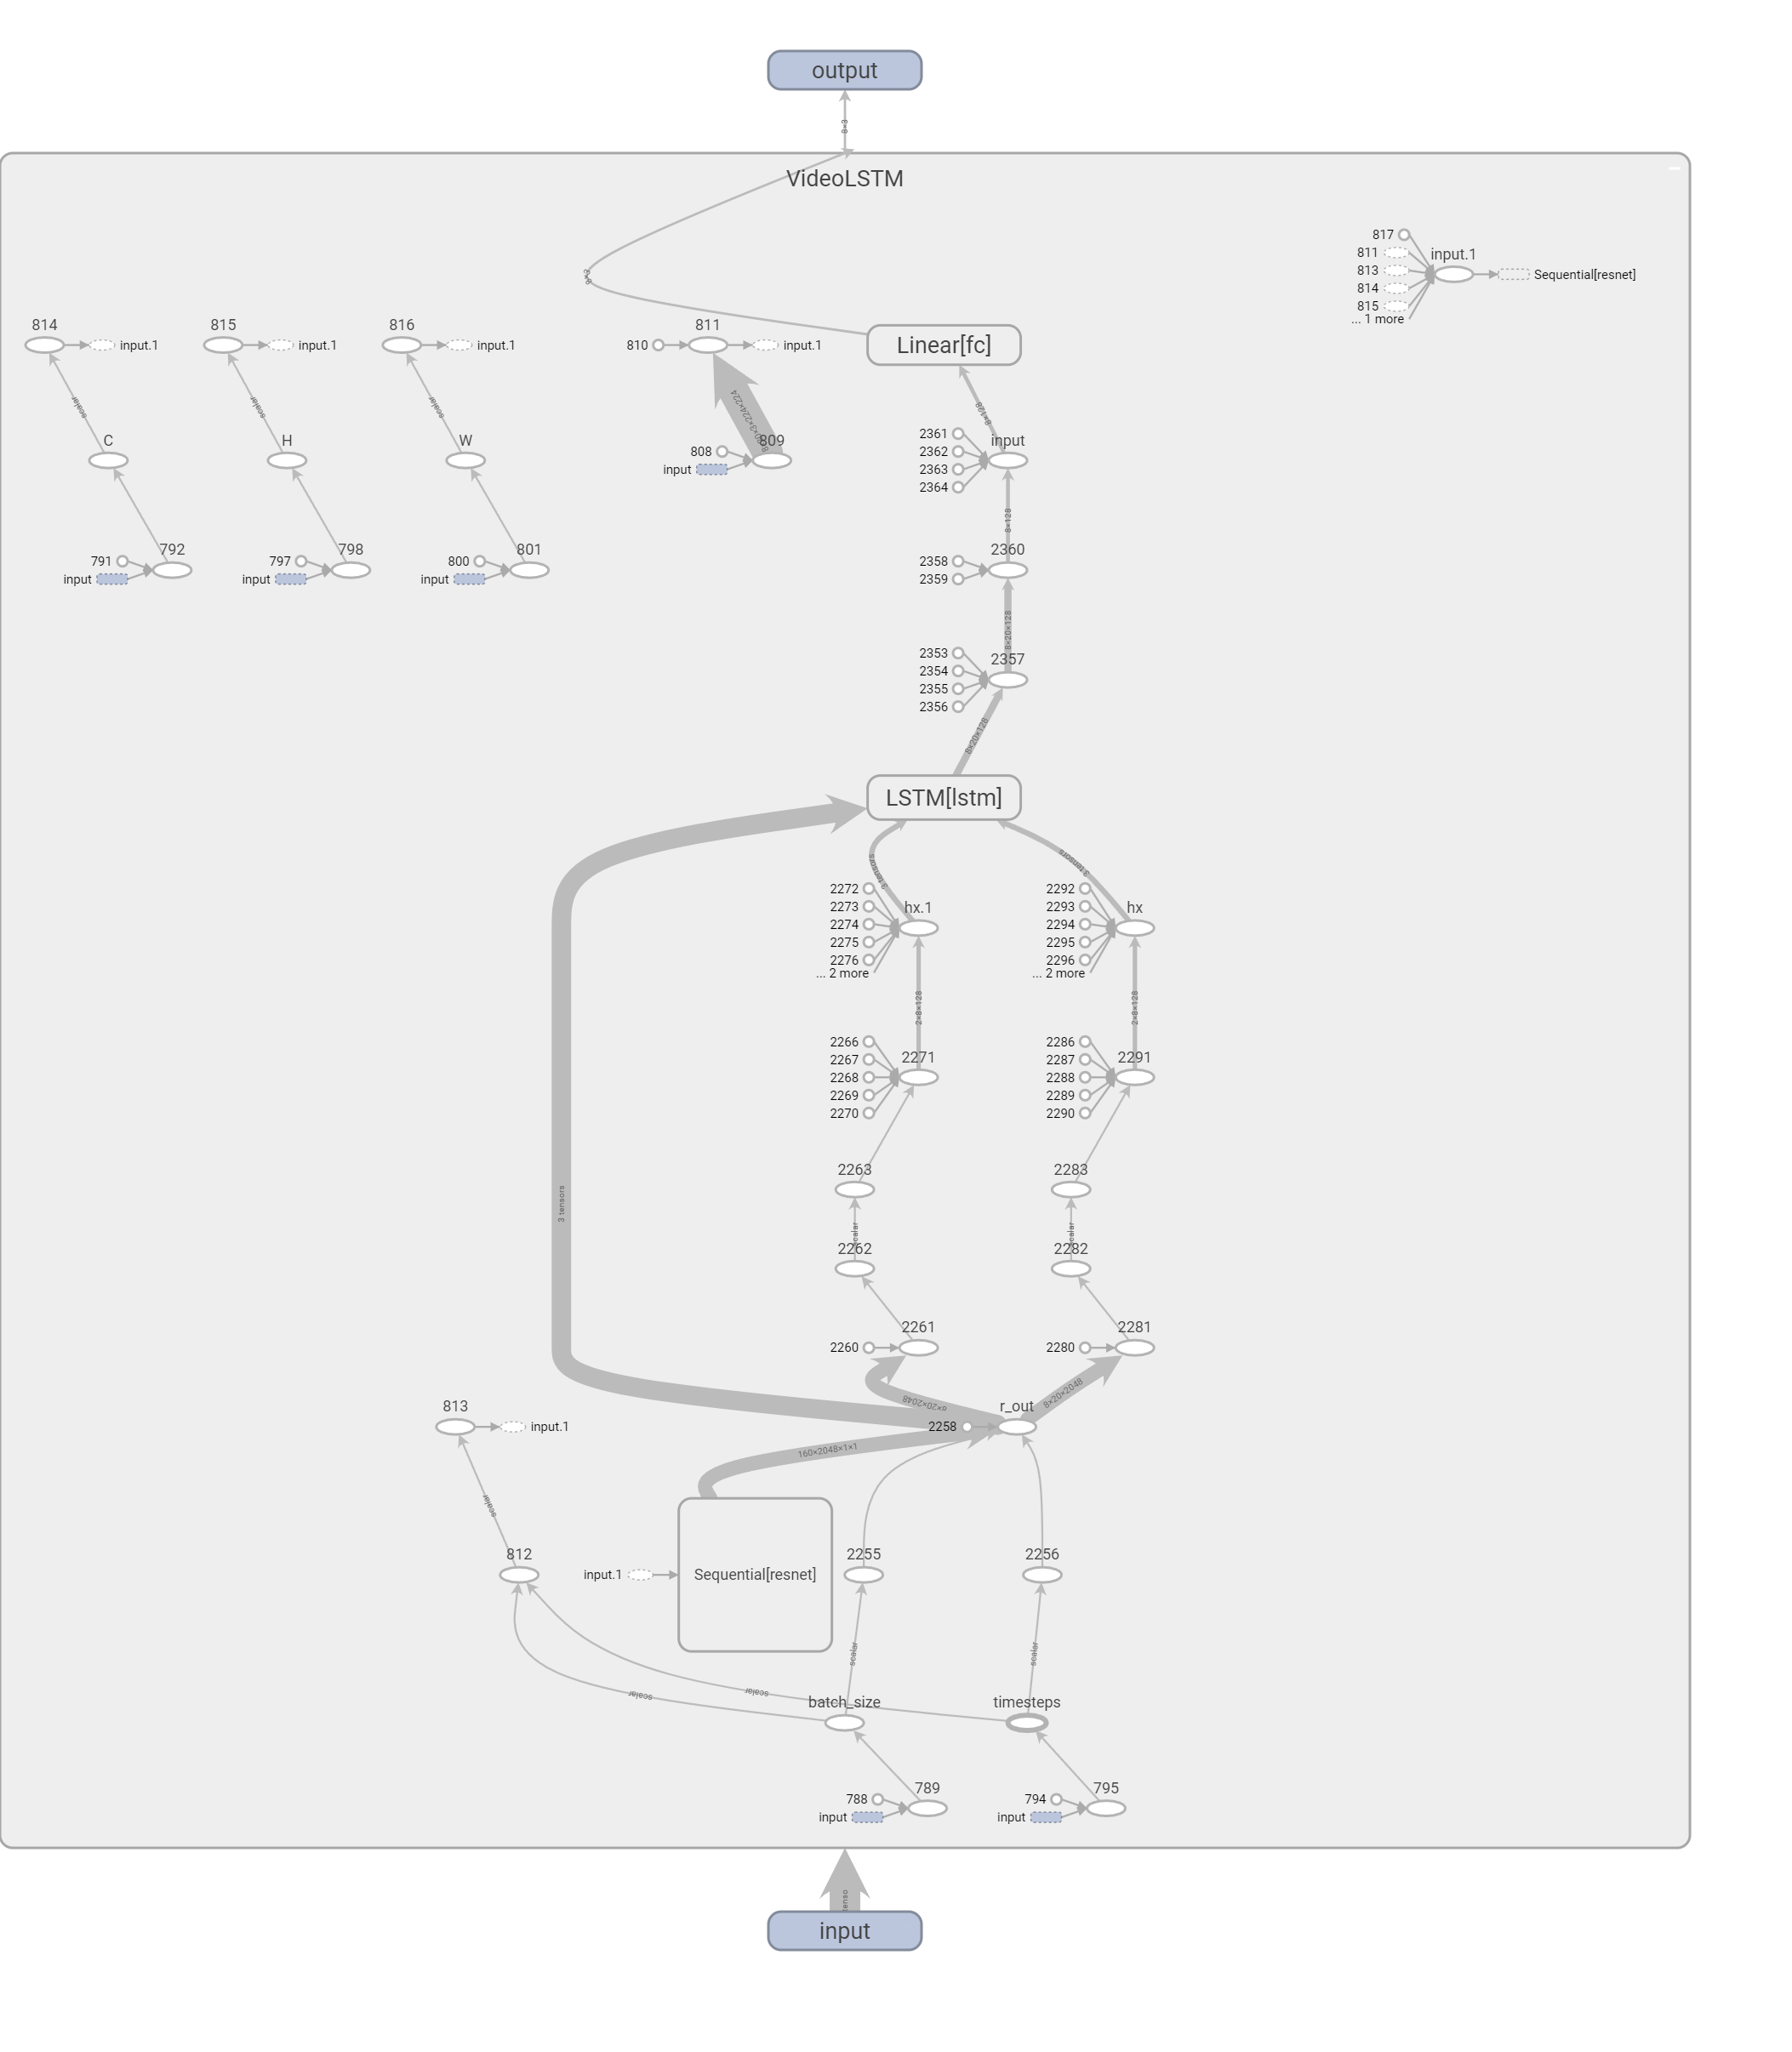

In [16]:
class VideoLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes):
        super(VideoLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Load a pre-trained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # LSTM layer
        self.lstm = nn.LSTM(2048, hidden_size, num_layers, batch_first=True)

        # Fully connected layer6
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, C, timesteps, H, W = x.size()
        c_in = x.permute(0, 2, 1, 3, 4).contiguous().view(batch_size * timesteps, C, H, W)
        c_out = self.resnet(c_in)

        r_out = c_out.view(batch_size, timesteps, -1)

        h0 = torch.zeros(self.num_layers, r_out.size(0), self.hidden_size).to(r_out.device)
        c0 = torch.zeros(self.num_layers, r_out.size(0), self.hidden_size).to(r_out.device)

        out, _ = self.lstm(r_out, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

# Model parameters
hidden_size = 128
num_layers = 2
num_classes = 3  # Number of classes

model = VideoLSTM(hidden_size, num_layers, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.4MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [18]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

model.to(device)

num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_count = 0
    torch.cuda.empty_cache()
    for batch in train_loader:

        videos = batch['video'].to(device)
        # print(videos.shape)
        labels = batch['label'].to(device)

        outputs = model(videos)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1
    avg_train_loss = total_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        batch_count = 0
        for batch in valid_loader:
            videos = batch['video'].to(device)
            labels = batch['label'].to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            batch_count += 1
    avg_val_loss = total_loss / batch_count
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, validation accuracy: {accuracy * 100:.2f}%')


Training on device: cuda


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [1/20], Training Loss: 1.0647, Validation Loss: 1.0460, validation accuracy: 40.43%
Epoch [2/20], Training Loss: 0.9785, Validation Loss: 0.9391, validation accuracy: 56.52%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [3/20], Training Loss: 0.9333, Validation Loss: 1.0014, validation accuracy: 47.83%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [4/20], Training Loss: 0.9199, Validation Loss: 0.9392, validation accuracy: 50.00%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [5/20], Training Loss: 0.8314, Validation Loss: 0.8708, validation accuracy: 63.04%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [6/20], Training Loss: 0.8169, Validation Loss: 0.9760, validation accuracy: 52.17%
Epoch [7/20], Training Loss: 0.8387, Validation Loss: 1.1064, validation accuracy: 50.00%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [8/20], Training Loss: 0.7701, Validation Loss: 1.0748, validation accuracy: 47.83%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [9/20], Training Loss: 0.9171, Validation Loss: 1.0070, validation accuracy: 52.17%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [10/20], Training Loss: 0.8297, Validation Loss: 0.8535, validation accuracy: 63.04%
Epoch [11/20], Training Loss: 0.7872, Validation Loss: 0.8588, validation accuracy: 54.35%
Epoch [12/20], Training Loss: 0.7575, Validation Loss: 0.8672, validation accuracy: 60.87%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [13/20], Training Loss: 0.6952, Validation Loss: 0.7674, validation accuracy: 69.57%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [14/20], Training Loss: 0.6845, Validation Loss: 0.9381, validation accuracy: 50.00%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [15/20], Training Loss: 0.6960, Validation Loss: 0.9927, validation accuracy: 60.87%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [16/20], Training Loss: 0.6677, Validation Loss: 1.0922, validation accuracy: 45.65%
Epoch [17/20], Training Loss: 0.7918, Validation Loss: 0.8018, validation accuracy: 65.22%


ERROR:libav.libdav1d:Error parsing OBU data


Epoch [18/20], Training Loss: 0.8714, Validation Loss: 0.8278, validation accuracy: 63.04%
Epoch [19/20], Training Loss: 0.6584, Validation Loss: 0.8794, validation accuracy: 60.87%
Epoch [20/20], Training Loss: 0.5784, Validation Loss: 0.7519, validation accuracy: 72.34%
CPU times: user 13min 5s, sys: 41.8 s, total: 13min 47s
Wall time: 46min 38s


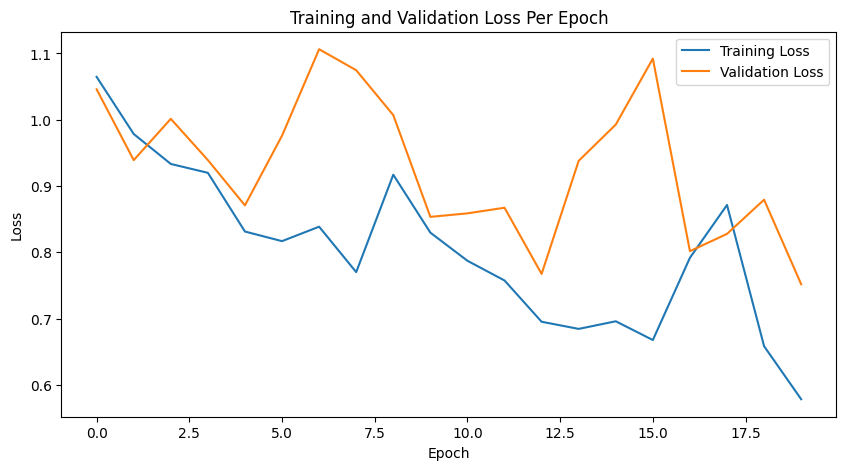

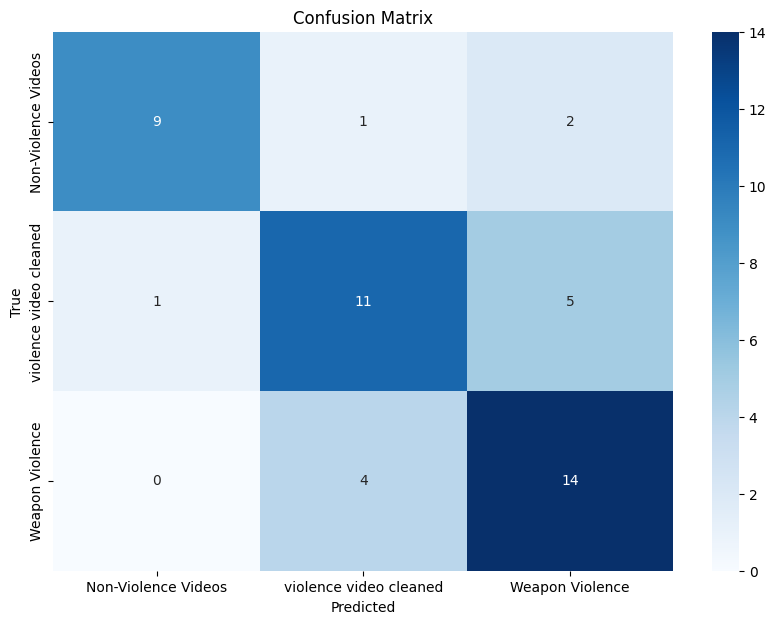

In [19]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# prompt: Evaluate the model on test loader

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_laoder:
        videos = batch['video'].to(device)
        labels = batch['label'].to(device)
        outputs = model(videos)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
# accuracy = accuracy_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.60      0.56      0.58        16
           2       0.60      0.47      0.53        19

    accuracy                           0.63        46
   macro avg       0.63      0.68      0.64        46
weighted avg       0.62      0.63      0.62        46



In [25]:
# This is just to see how the model do if the problem is to detect violence in general

all_preds = [1 if x == 2 else x for x in all_preds]
all_labels = [1 if x == 2 else x for x in all_labels]

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.86      0.92        35

    accuracy                           0.89        46
   macro avg       0.84      0.93      0.87        46
weighted avg       0.93      0.89      0.90        46

